[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds4v/absa-vlsp-2018/blob/main/ACSA-v2/Restaurant-v2.ipynb)

In [ ]:
from google.colab import drive
import os

drive.mount('/content/GoogleDrive', force_remount=True)
path = '/content/GoogleDrive/My Drive/ABSA'
os.chdir(path)
!ls

# Install & import libraries

In [ ]:
import numpy as np
import tensorflow as tf
import torch
tf.get_logger().setLevel('ERROR')
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.122.86.228)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by CenturyLink (Omaha, NE) [12.44 km]: 24.776 ms
Testing download speed................................................................................
Download: 1635.86 Mbit/s
Testing upload speed......................................................................................................
Upload: 117.02 Mbit/s


In [ ]:
!pip install -q datasets
!pip install -q transformers
!pip install -q tf-models-official

     |████████████████████████████████| 245kB 6.8MB/s 
     |████████████████████████████████| 245kB 61.4MB/s 
     |████████████████████████████████| 122kB 53.0MB/s 
     |████████████████████████████████| 2.5MB 6.8MB/s 
     |████████████████████████████████| 901kB 59.6MB/s 
     |████████████████████████████████| 3.3MB 60.1MB/s 
     |████████████████████████████████| 1.6MB 7.0MB/s 
     |████████████████████████████████| 102kB 8.9MB/s 
     |████████████████████████████████| 1.2MB 19.1MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 215kB 35.2MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 686kB 28.1MB/s 
     |████████████████████████████████| 358kB 39.4MB/s 
     |████████████████████████████████| 38.2MB 188kB/s 
     |████████████████████████████████| 645kB 58.2MB/s 


# Accelerator

## Check GPU working

In [ ]:
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
# print('Found GPU at:', device_name)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

## Connect to the TPU worker

In [ ]:
if os.environ['COLAB_TPU_ADDR']: 
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print('Using TPU')
    print("All devices: ", tf.config.list_logical_devices('TPU'))
elif tf.test.is_gpu_available():
    strategy = tf.distribute.MirroredStrategy()
    print('Using GPU')
else: raise ValueError('Running on CPU is not recommended.')

Using TPU
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Import & preprocess datasets

In [ ]:
TRAIN_PATH = 'dataset/VLSP_Restaurant/restaurant_train.csv'
VAL_PATH = 'dataset/VLSP_Restaurant/restaurant_val.csv'
TEST_PATH = 'dataset/VLSP_Restaurant/restaurant_test.csv'

In [ ]:
from datasets import load_dataset
raw_datasets = load_dataset('csv', data_files={'train': TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH})
raw_datasets

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-94fb08311543926b/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['Review', 'AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL'],
        num_rows: 2961
    })
    val: Dataset({
        features: ['AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'Review', 'SERVICE#GENERAL'],
        num_rows: 1290
    })
    test: Dataset({
        features: ['AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'Review', 'SERVICE#GENERAL'],
        num_rows: 500
    })
})

In [ ]:
import pandas as pd
df_train = pd.read_csv(TRAIN_PATH)
df_val = pd.read_csv(VAL_PATH)
df_test = pd.read_csv(TEST_PATH)
df_train.head(3)

,Review,AMBIENCE#GENERAL,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE&OPTIONS,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE&OPTIONS,LOCATION#GENERAL,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,RESTAURANT#PRICES,SERVICE#GENERAL
0,"_ ảnh chụp từ hôm qua, đi chơi với gia đình và...",0,0,0,0,0,3,3,0,0,0,0,0
1,"_hương vị thơm ngon, ăn cay cay rất thích, nêm...",1,0,0,0,3,1,1,0,1,0,3,2
2,- 1 bàn tiệc hoành tráng 3 đứa ăn no muốn tắt ...,2,0,0,0,1,1,1,2,1,1,0,1


In [ ]:
!pip install -q emoji
!pip install -q vncorenlp
!git clone https://github.com/vncorenlp/VnCoreNLP.git

Cloning into 'VnCoreNLP'...
remote: Enumerating objects: 212, done.
remote: Total 212 (delta 0), reused 0 (delta 0), pack-reused 212
Receiving objects: 100% (212/212), 214.21 MiB | 34.49 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Checking out files: 100% (33/33), done.


In [ ]:
!rm -rf teencode.txt
!wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt

--2021-07-03 18:06:05--  https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5656 (5.5K) [text/plain]
Saving to: ‘teencode.txt’

teencode.txt        100%[===================>]   5.52K  --.-KB/s    in 0.001s  

2021-07-03 18:06:05 (7.56 MB/s) - ‘teencode.txt’ saved [5656/5656]



In [ ]:
from preprocess import (
    remove_HTML, 
    convert_unicode, 
    # standardize_sentence_typing, 
    normalize_acronyms, 
    word_segmentation, # When use PhoBERT
    remove_unnecessary_characters
)

In [ ]:
def text_preprocess(text):
    text = remove_HTML(text)
    text = convert_unicode(text) 
    # text = standardize_sentence_typing(text)
    text = normalize_acronyms(text)
    text = word_segmentation(text) # When use PhoBERT
    text = remove_unnecessary_characters(text)
    # return text.lower()
    return text

In [ ]:
#@title **Choose a pretrained model for Vietnamese that support Tensorflow from [huggingface](https://huggingface.co/transformers/pretrained_models.html)**
#@markdown
#@markdown | <h4>Model id                        </h4> | <h4>Summary                                                                              </h4> | <h4>Description                                                                                                       </h4> | <h4>Architecture</h4> |
#@markdown | ----------------------------------------- | ---------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------- | --------------------- |
#@markdown | <p>vinai/phobert-base                </p> | <p>135M parameters                                                                        </p> | <p>Trained on 20GB of texts                                                                                            </p> | <p>RoBERTa       </p> |
#@markdown | <p>vinai/phobert-large               </p> | <p>370M parameters                                                                        </p> | <p>Trained on 20GB of texts                                                                                            </p> | <p>RoBERTa       </p> |
#@markdown | <p>bert-base-multilingual-uncased    </p> | <p>12-layer, 768-hidden, 12-heads, 168M parameters                                        </p> | <p>(Original, not recommended) Trained on lower-cased text in the top 102 languages with the largest Wikipedias        </p> | <p>BERT          </p> |
#@markdown | <p>bert-base-multilingual-cased      </p> | <p>12-layer, 768-hidden, 12-heads, 179M parameters                                        </p> | <p>(New, recommended) Trained on cased text in the top 104 languages with the largest Wikipedias                       </p> | <p>BERT          </p> |
#@markdown | <p>distilbert-base-multilingual-cased</p> | <p>6-layer, 768-hidden, 12-heads, 134M parameters                                         </p> | <p>The multilingual DistilBERT model distilled from the Multilingual BERT model bert-base-multilingual-cased checkpoint</p> | <p>DistilBERT    </p> |
#@markdown >

PRETRAINED_MODEL = 'vinai/phobert-base' #@param ['vinai/phobert-base', 'vinai/phobert-large', 'bert-base-multilingual-uncased','bert-base-multilingual-cased ', 'distilbert-base-multilingual-cased'] {allow-input: true}

## Tokenizing

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokenizer.max_model_input_sizes

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'vinai/phobert-base': 256, 'vinai/phobert-large': 256}

In [ ]:
# tokens = tokenizer.encode('Tôi là sinh viên trường đại học Công nghệ thông tin .') 
tokens = tokenizer.encode('Tôi là sinh_viên trường đại_học Công_nghệ thông_tin .') # When use PhoBERT
print('Encode:', tokens)
print('Decode:', tokenizer.decode(tokens))

Encode: [0, 218, 8, 649, 212, 956, 2413, 195, 5, 2]
Decode: <s> Tôi là sinh_viên trường đại_học Công_nghệ thông_tin. </s>


In [ ]:
# https://huggingface.co/transformers/preprocessing.html
def tokenize_function(dataset):
    clean_texts = list(map(text_preprocess, dataset['Review']))
    return tokenizer(clean_texts, max_length=tokenizer.model_max_length, padding='max_length', truncation=True)

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print('input_ids of sentence 1484:', tokenized_datasets['train'][1484]['input_ids'])


input_ids of sentence 1484: [0, 4650, 2198, 1476, 33626, 6262, 6, 7873, 1111, 33626, 6262, 1329, 36, 14972, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Prepare for TensorFlow

In [ ]:
MAX_SEQUENCE_LENGTH = tokenizer.model_max_length
MODEL_PATH = 'ACSA-v2/Restaurant'
BATCH_SIZE = 21

STEPS_PER_EPOCH = len(raw_datasets['train']) // BATCH_SIZE
VALIDATION_STEPS = len(raw_datasets['val']) // BATCH_SIZE
EPOCHS = 20

In [ ]:
def to_tensorflow_format(tokenized_dataset, type='features'):
    features = list(tokenized_dataset.features)
    if type == 'features': col_names = features[:-3]
    elif type == 'targets': col_names = features[-3:] + ['Review']
    return tokenized_dataset.remove_columns(col_names).with_format('tensorflow')

In [ ]:
def standardize_labels(dataset):
    tf_dataset = to_tensorflow_format(dataset, type='targets')
    standard_labels = {}
    for key, value in tf_dataset.to_dict().items():
        key = key.replace('#', '-').replace('&', '_')
        standard_labels[key] = np.array(value, dtype='uint8')
    return standard_labels

In [ ]:
from tensorflow.data import Dataset
def preprocess_tokenized_dataset(tokenized_dataset, tokenizer, batch_size, shuffle=False):
    tf_dataset = to_tensorflow_format(tokenized_dataset)
    features = {x: tf_dataset[x].to_tensor() for x in tf_dataset.features}
    labels = standardize_labels(tokenized_dataset)

    tf_dataset = Dataset.from_tensor_slices((features, labels))
    if shuffle: tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset))
    return tf_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['train'], tokenizer, BATCH_SIZE, shuffle=True)
val_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['val'], tokenizer, BATCH_SIZE)
test_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['test'],  tokenizer, BATCH_SIZE)
train_tf_dataset

# Fine-tuning with TensorFlow

## Define the model

In [ ]:
from transformers import TFAutoModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate

def create_model(optimizer):
    # https://riccardo-cantini.netlify.app/post/bert_text_classification
    inputs = {
        'input_ids'     : Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_ids'), 
        'token_type_ids': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='token_type_ids'), 
        'attention_mask': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='attention_mask')
    }
    pretrained_bert = TFAutoModel.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True)
    hidden_states = pretrained_bert(inputs).hidden_states

    # https://github.com/huggingface/transformers/issues/1328
    pooled_output = concatenate(
        tuple([hidden_states[i] for i in range(-4, 0)]), 
        name = 'last_4_hidden_states',
        axis = -1
    )[:, 0, :]
    x = Dropout(0.2)(pooled_output)
    print(pooled_output)

    outputs = [
        Dense(
            units = 4, 
            activation = 'softmax', 
            name = label
        )(x) for label in list(train_tf_dataset.element_spec[1])
    ]
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
    return model

## Optimzers

In [ ]:
# from tensorflow.keras.optimizers import Adam
# optimizer = Adam(learning_rate=2e-5)
# type(optimizer)

In [ ]:
from official.nlp import optimization
num_train_steps = STEPS_PER_EPOCH * EPOCHS
optimizer = optimization.create_optimizer(
    init_lr = 2e-4, 
    num_train_steps = num_train_steps, 
    num_warmup_steps = num_train_steps // 10
)
type(optimizer)

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


official.nlp.optimization.AdamWeightDecay

## Callbacks

In [ ]:
# from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

# # Keeps initial learning rate for first 6 epochs decreases it exponentially  after that.
# def scheduler(epoch, lr):
#     if epoch < 6: return lr
#     return lr * tf.math.exp(-0.1)
# schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# # Reduce the learning rate once learning stagnates => new_lr = lr * factor. 
# reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions

# Stop if no improvement after 5 epochs
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint_path = MODEL_PATH + '/checkpoints/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Prevent from UnimplementedError when using TPU
options = CheckpointOptions(experimental_io_device='/job:localhost')

# Create a callback that saves the model's weights every 10 epochs
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path, 
    save_best_only = True,
    save_weights_only = True,
    save_freq = 10 * STEPS_PER_EPOCH, 
    options = options,  
    verbose = 1
)

## Training

In [ ]:
with strategy.scope(): # For using TPU
    model = create_model(optimizer)
    history = model.fit(
        train_tf_dataset, 
        validation_data = val_tf_dataset, 
        validation_steps = VALIDATION_STEPS,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = EPOCHS,
        callbacks = [
            # schedule_lr_callback, # When not use AdamW
            # reduce_lr_callback, # When not use AdamW
            early_stop_callback, 
            # checkpoint_callback
        ],
        verbose = 1,
    )
    model.save_weights(f'{MODEL_PATH}/weights.h5')

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")
Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_5:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_6:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_7:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_8:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_9:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_10:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_11:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_12:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_13:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_14:0' shape=(

141/141 [==============================] - ETA: 0s - loss: 7.6193 - AMBIENCE-GENERAL_loss: 0.7429 - DRINKS-PRICES_loss: 0.3260 - DRINKS-QUALITY_loss: 0.2997 - DRINKS-STYLE_OPTIONS_loss: 0.2736 - FOOD-PRICES_loss: 1.1461 - FOOD-QUALITY_loss: 0.7871 - FOOD-STYLE_OPTIONS_loss: 0.9896 - LOCATION-GENERAL_loss: 0.5941 - RESTAURANT-GENERAL_loss: 0.7552 - RESTAURANT-MISCELLANEOUS_loss: 0.3862 - RESTAURANT-PRICES_loss: 0.5279 - SERVICE-GENERAL_loss: 0.7906

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_5:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_6:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_7:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_8:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_9:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_10:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_11:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_12:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_13:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_14:0' shape=(

141/141 [==============================] - 111s 228ms/step - loss: 7.6193 - AMBIENCE-GENERAL_loss: 0.7429 - DRINKS-PRICES_loss: 0.3260 - DRINKS-QUALITY_loss: 0.2997 - DRINKS-STYLE_OPTIONS_loss: 0.2736 - FOOD-PRICES_loss: 1.1461 - FOOD-QUALITY_loss: 0.7871 - FOOD-STYLE_OPTIONS_loss: 0.9896 - LOCATION-GENERAL_loss: 0.5941 - RESTAURANT-GENERAL_loss: 0.7552 - RESTAURANT-MISCELLANEOUS_loss: 0.3862 - RESTAURANT-PRICES_loss: 0.5279 - SERVICE-GENERAL_loss: 0.7906 - val_loss: 4.6808 - val_AMBIENCE-GENERAL_loss: 0.3873 - val_DRINKS-PRICES_loss: 0.1516 - val_DRINKS-QUALITY_loss: 0.1522 - val_DRINKS-STYLE_OPTIONS_loss: 0.0514 - val_FOOD-PRICES_loss: 0.7683 - val_FOOD-QUALITY_loss: 0.5998 - val_FOOD-STYLE_OPTIONS_loss: 0.8200 - val_LOCATION-GENERAL_loss: 0.3492 - val_RESTAURANT-GENERAL_loss: 0.5041 - val_RESTAURANT-MISCELLANEOUS_loss: 0.3994 - val_RESTAURANT-PRICES_loss: 0.1591 - val_SERVICE-GENERAL_loss: 0.3382
Epoch 2/20
141/141 [==============================] - 18s 131ms/step - loss: 4.8895 - A

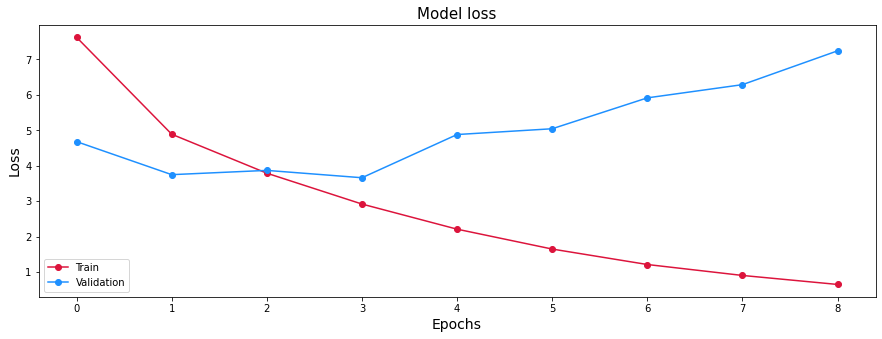

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Model loss', fontsize=15)
plt.legend(loc='best')
fig.savefig(f'{MODEL_PATH}/evaluation.png', bbox_inches='tight') 
plt.show()

## Reload the model

In [ ]:
from tensorflow.train import latest_checkpoint
with strategy.scope():
    reloaded_model = create_model(optimizer)
    # reloaded_model.load_weights(latest_checkpoint(checkpoint_dir))
    reloaded_model.load_weights(f'{MODEL_PATH}/weights.h5')
    reloaded_model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name=None), name='tf.__operators__.getitem_1/strided_slice:0', description="created by layer 'tf.__operators__.getitem_1'")
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 256)]        0                                            
_______________________________________________________________________________________________

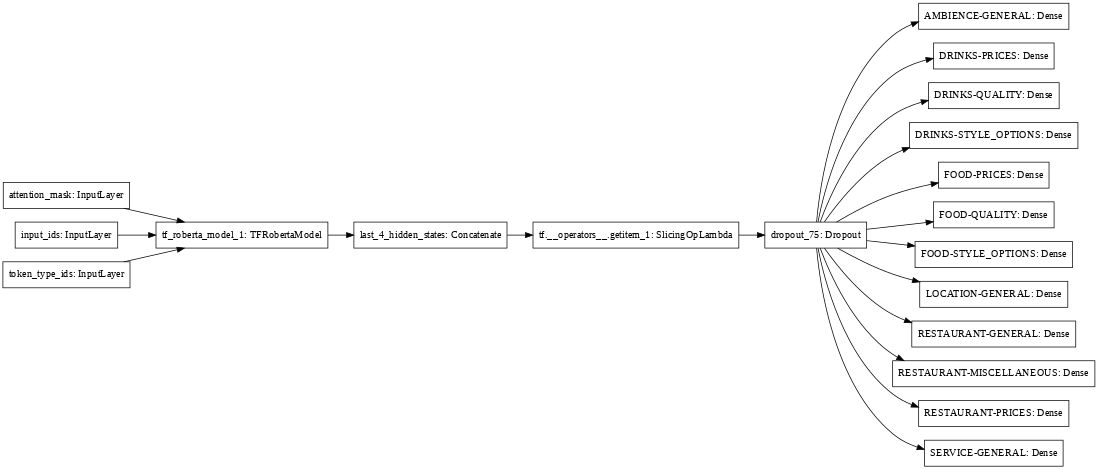

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(reloaded_model, to_file=f'{MODEL_PATH}/architecture.png', rankdir='LR', dpi=52)

# Prediction

In [ ]:
y_test = raw_datasets['test'].remove_columns('Review')
y_test = np.array(y_test.to_pandas())
y_test

array([[0, 3, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 3, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 0, 0]])

## Predict on test data

In [ ]:
def print_acsa_pred(replacements, categories, sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments): 
        if sentiment: print(f'=> {category},{sentiment}')

In [ ]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    return np.argmax(y_pred, axis=-1).T # sentiment values (position that have max value)

In [ ]:
with strategy.scope():
    y_pred = predict(reloaded_model, test_tf_dataset, BATCH_SIZE, verbose=1)
    reloaded_model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_5:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_6:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_7:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_8:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_9:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_10:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_11:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_12:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_13:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_14:0' shape=(

24/24 [==============================] - 14s 354ms/step


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_5:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_6:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_7:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_8:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_9:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_10:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_11:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_12:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_13:0' shape=(None,) dtype=uint8>, <tf.Tensor 'cond_8/Identity_14:0' shape=(

24/24 [==============================] - 20s 52ms/step - loss: 9.1941 - AMBIENCE-GENERAL_loss: 0.7346 - DRINKS-PRICES_loss: 0.5466 - DRINKS-QUALITY_loss: 0.3400 - DRINKS-STYLE_OPTIONS_loss: 0.2929 - FOOD-PRICES_loss: 1.0051 - FOOD-QUALITY_loss: 0.6088 - FOOD-STYLE_OPTIONS_loss: 0.9240 - LOCATION-GENERAL_loss: 0.6797 - RESTAURANT-GENERAL_loss: 1.7419 - RESTAURANT-MISCELLANEOUS_loss: 1.0700 - RESTAURANT-PRICES_loss: 0.6853 - SERVICE-GENERAL_loss: 0.5651


In [ ]:
replacements = {0: None, 1: 'positive', 2: 'negative', 3: 'neutral'}
categories = df_test.columns[1:]
print('Example:', df_test['Review'][0])
print_acsa_pred(replacements, categories, y_pred[0])

Example: đây là 1 trong những quán mà mình thích vì vị trà đậm và thơm cũng như mùi vị đặc trưng hơn hẳn những quán khác nè  trà sữa trân châu sợi - 46k trà sữa pha khá ngon, vị trà chát và mùi hương khá rõ, không quá ngọt, rất đúng với gu mình  trà đào - 45k vị trà đào ở đây cũng đặc biệt hơn hẳn những quán khác, không phải chua ngọt như thưởng thấy mà có mùi trà rất ngon  cà phê đá xay - 65k món đá xay ở đây uống cũng ngon không kém trà nè, mùi vị thơm hương cà phê, vị đắng kết hợp hoàn hảo với độ béo ngọt của whipping cream, không quá đắng, cũng không quá ngọt hay lạt lẽo mà dịu nhẹ, thơm và dễ uống lắm  trà vải thiết quan âm - 45k trà vải có mùi vị rất thơm ngon mùi vải mà vẫn nghe rõ vị trà, có chút vị chát nhẹ mùi trà thơm rất thích, không phải chỉ toàn vị syrup vải ngọt gắt như nhiều chỗ khác. do trà ở đây pha khá đậm nên bạn nào uống mà đang đói sẽ dễ say nha, hoặc ban đêm có thể khó ngủ à, cảnh báo trước  trà thiết quan âm latte - 47k ly này thì vị trà rất đậm nên cảm giác hơi

## Predict random text

In [ ]:
example_input = text_preprocess(input('Enter your sentence: '))
tokenized_input = tokenizer(example_input, padding='max_length', truncation=True)
features = {x: [[tokenized_input[x]]] for x in tokenizer.model_input_names}

with strategy.scope():
    pred = predict(reloaded_model, Dataset.from_tensor_slices(features))
    print_acsa_pred(replacements, categories, pred[0])

Enter your sentence: Giá cũng ok mà nhân viên hơi thiếu chuyên nghiệp


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 256) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 256) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 256) dtype=int32>]


=> FOOD#PRICES,positive
=> FOOD#QUALITY,positive
=> RESTAURANT#PRICES,positive
=> SERVICE#GENERAL,negative


# Report metrics

## Aspect Detection

In [ ]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])

In [ ]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

                          precision    recall  f1-score   support

                             0.9111    0.8609    0.8853      3581
        AMBIENCE#GENERAL     0.8782    0.9333    0.9049       255
           DRINKS#PRICES     0.5700    0.7500    0.6477        76
          DRINKS#QUALITY     0.6761    0.6761    0.6761        71
    DRINKS#STYLE&OPTIONS     0.4912    0.6087    0.5437        46
             FOOD#PRICES     0.8453    0.9577    0.8980       331
            FOOD#QUALITY     0.9553    0.9825    0.9687       457
      FOOD#STYLE&OPTIONS     0.9097    0.9504    0.9296       403
        LOCATION#GENERAL     0.8104    0.9553    0.8769       179
      RESTAURANT#GENERAL     0.5673    0.8879    0.6923       223
RESTAURANT#MISCELLANEOUS     0.9344    0.4385    0.5969       130
       RESTAURANT#PRICES     0.3871    0.3288    0.3556        73
         SERVICE#GENERAL     0.8810    0.8457    0.8630       175

                accuracy                         0.8668      6000
        

## Polarity Detection

In [ ]:
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()
target_names = list(map(str, replacements.values()))

In [ ]:
polarity_report = classification_report(y_test_flat, y_pred_flat, digits=4, output_dict=True)
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names, digits=4))

              precision    recall  f1-score   support

        None     0.9111    0.8609    0.8853      3581
    positive     0.7289    0.8280    0.7753      1669
    negative     0.4758    0.3711    0.4170       159
     neutral     0.6007    0.6058    0.6032       591

    accuracy                         0.8137      6000
   macro avg     0.6791    0.6664    0.6702      6000
weighted avg     0.8183    0.8137    0.8145      6000



## Aspect + Polarity

In [ ]:
aspect_polarity_test = []
aspect_polarity_pred = []

for row_test, row_pred in zip(y_test, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_polarity_test.append(f'{categories[index]},{replacements[col_test]}')
        aspect_polarity_pred.append(f'{categories[index]},{replacements[col_pred]}')

In [ ]:
aspect_polarity_report = classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1))

                                   precision    recall  f1-score   support

            AMBIENCE#GENERAL,None     0.9258    0.8653    0.8945       245
        AMBIENCE#GENERAL,negative     0.7273    0.3077    0.4324        26
         AMBIENCE#GENERAL,neutral     0.4464    0.5208    0.4808        48
        AMBIENCE#GENERAL,positive     0.8186    0.9227    0.8675       181
               DRINKS#PRICES,None     0.9525    0.8986    0.9248       424
           DRINKS#PRICES,negative     0.0000    0.0000    0.0000         3
            DRINKS#PRICES,neutral     0.5122    0.4667    0.4884        45
           DRINKS#PRICES,positive     0.3333    0.5714    0.4211        28
              DRINKS#QUALITY,None     0.9464    0.9464    0.9464       429
          DRINKS#QUALITY,negative     1.0000    0.0000    0.0000         6
           DRINKS#QUALITY,neutral     0.4000    0.1818    0.2500        11
          DRINKS#QUALITY,positive     0.5152    0.6296    0.5667        54
        DRINKS#STYLE&OPT

## Summary

In [ ]:
aspect_dict = aspect_report['macro avg']
aspect_dict['accuracy'] = aspect_report['accuracy']

polarity_dict  = polarity_report['macro avg']
polarity_dict['accuracy'] = polarity_report['accuracy']

aspect_polarity_dict = aspect_polarity_report['macro avg']
aspect_polarity_dict['accuracy'] = aspect_polarity_report['accuracy']

In [ ]:
df_report = pd.DataFrame.from_dict([aspect_dict, polarity_dict, aspect_polarity_dict])
df_report.index = ['Aspect Detection', 'Polarity Detection', 'Aspect + Polarity']
df_report.drop('support', axis=1)

,precision,recall,f1-score,accuracy
Aspect Detection,0.755169,0.782749,0.756820,0.866833
Polarity Detection,0.679108,0.666449,0.670190,0.813667
Aspect + Polarity,0.648890,0.538006,0.545214,0.813667


# Export to VLSP format

In [ ]:
vlsp_results = []
for index, pred in enumerate(y_pred):
    sentiments = map(lambda x: replacements[x], pred)
    result = {
        'id': f'#{index + 1}',
        'text': df_test.Review[index],
        'acsa': []
    }
    for category, sentiment in zip(categories, sentiments): 
        if sentiment: result['acsa'].append('{'+ category + ', ' + sentiment + '}')
    vlsp_results.append(result)
vlsp_results[:3]

[{'acsa': ['{DRINKS#PRICES, neutral}',
   '{DRINKS#QUALITY, positive}',
   '{DRINKS#STYLE&OPTIONS, positive}',
   '{FOOD#PRICES, neutral}',
   '{FOOD#QUALITY, positive}',
   '{RESTAURANT#GENERAL, negative}'],
  'id': '#1',
  'text': 'đây là 1 trong những quán mà mình thích vì vị trà đậm và thơm cũng như mùi vị đặc trưng hơn hẳn những quán khác nè  trà sữa trân châu sợi - 46k trà sữa pha khá ngon, vị trà chát và mùi hương khá rõ, không quá ngọt, rất đúng với gu mình  trà đào - 45k vị trà đào ở đây cũng đặc biệt hơn hẳn những quán khác, không phải chua ngọt như thưởng thấy mà có mùi trà rất ngon  cà phê đá xay - 65k món đá xay ở đây uống cũng ngon không kém trà nè, mùi vị thơm hương cà phê, vị đắng kết hợp hoàn hảo với độ béo ngọt của whipping cream, không quá đắng, cũng không quá ngọt hay lạt lẽo mà dịu nhẹ, thơm và dễ uống lắm  trà vải thiết quan âm - 45k trà vải có mùi vị rất thơm ngon mùi vải mà vẫn nghe rõ vị trà, có chút vị chát nhẹ mùi trà thơm rất thích, không phải chỉ toàn vị sy

In [ ]:
with open('ACSA-v2-restaurant.txt', 'w', encoding='utf-8') as f:
    for result in vlsp_results:
        id, text, acsa = result.values()
        f.write(f"{id}\n{text}\n{', '.join(acsa)}\n\n")

In [ ]:
import gc
del model
torch.cuda.empty_cache()
gc.collect()